In [2]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr

In [3]:
ds_train=pd.read_csv("train_hora.csv")
ds_train["date"]=pd.to_datetime(ds_train["date"],format="%Y-%m-%d %H:%M:%S")
ds_train=ds_train.set_index("date")
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


In [200]:
ds_test=pd.read_csv("test_hora.csv")
ds_test["date"]=pd.to_datetime(ds_test["date"],format="%Y-%m-%d %H:%M:%S")
ds_test=ds_test.set_index("date")
ds_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


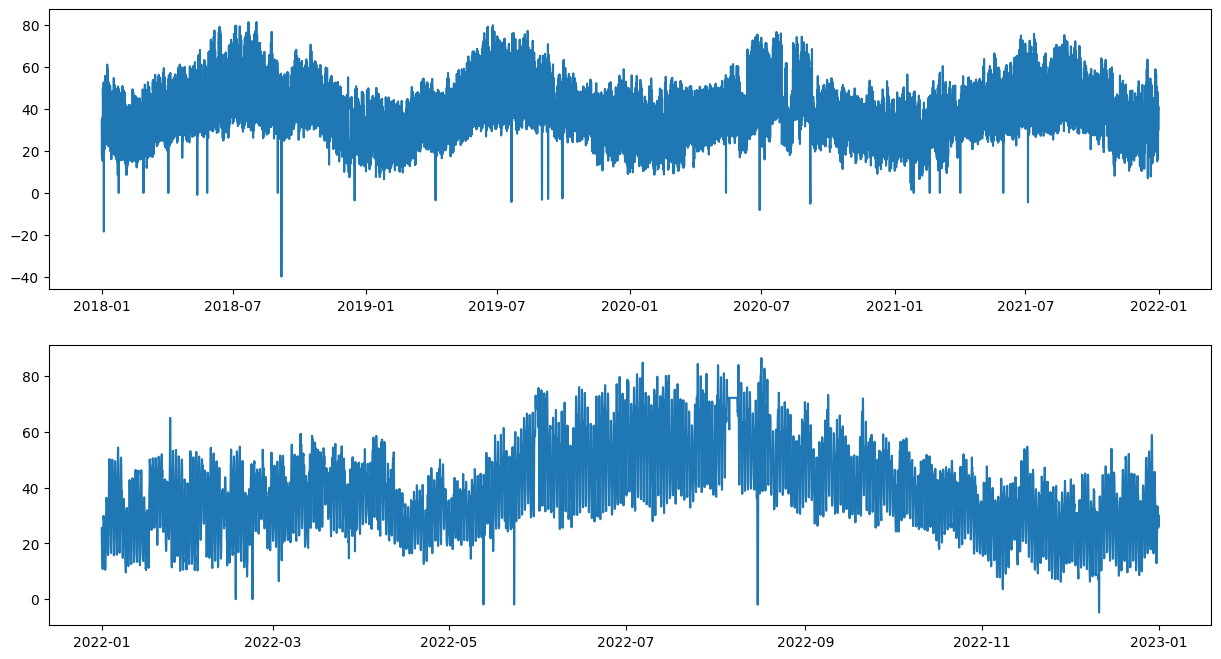

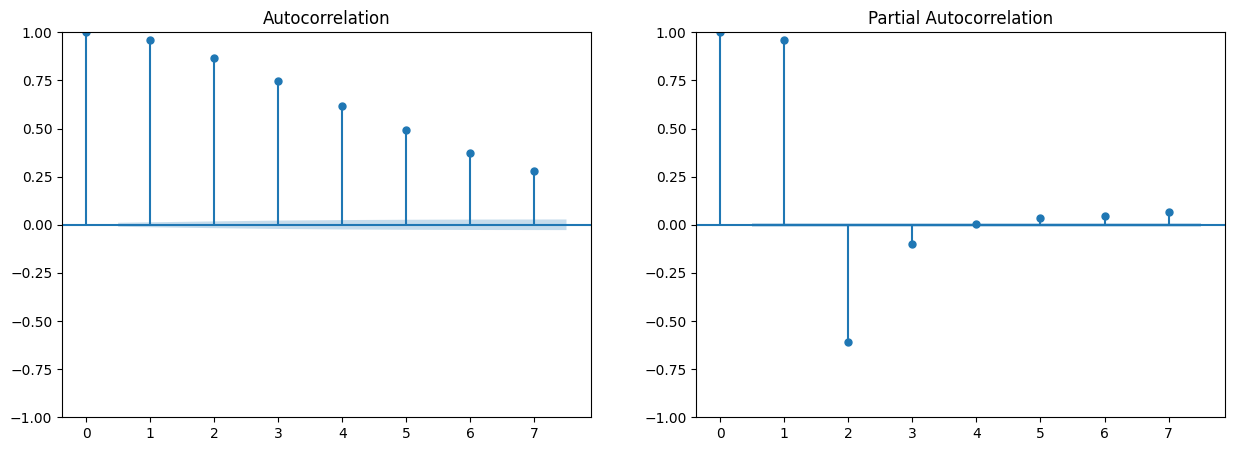

In [170]:
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);


In [171]:
t_interp=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_interp.csv",sep=";")
t_interp["date"]=pd.to_datetime(t_interp["date"],format="%Y-%m-%d %H:%M:%S")
t_interp=t_interp.set_index("date")
inicio=datetime.datetime.strptime("2017-12-31 17:00:00", '%Y-%m-%d %H:%M:%S')
t_interp_inicio=t_interp.loc[inicio]
fin= datetime.datetime.strptime("2023-01-01 07:00:00", '%Y-%m-%d %H:%M:%S')
t_interp_fin=t_interp.loc[fin]
t_interp=t_interp.query("date.dt.year>2017 and date.dt.year<2023")
t_interp.loc[fin]=t_interp_fin
t_interp.loc[inicio]=t_interp_inicio
t_interp.sort_index(inplace=True)
t_interp.head()

,t_interp
date,
2017-12-31 17:00:00,28.4
2018-01-01 07:00:00,12.8
2018-01-01 17:00:00,28.9
2018-01-02 07:00:00,12.4
2018-01-02 17:00:00,30.2


In [172]:
t_media=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_media.csv",sep=";")
t_media["date"]=pd.to_datetime(t_media["date"],format="%Y-%m-%d %H:%M:%S")
t_media=t_media.set_index("date")
fin= datetime.datetime.strptime("2023-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
t_media_fin=t_media.loc[fin]
t_media=t_media.query("date.dt.year>2017 and date.dt.year<2023")
t_media.loc[fin]=t_media_fin
t_media.sort_index(inplace=True)
t_media.head()

,t_media
date,
2018-01-01,20.2
2018-01-02,21.1
2018-01-03,22.3
2018-01-04,21.9
2018-01-05,22.2


In [173]:
t_minima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_minima.csv",sep=";")
t_minima["date"]=pd.to_datetime(t_minima["date"],format="%Y-%m-%d %H:%M:%S")
t_minima=t_minima.set_index("date")
t_minima_fin=t_minima.loc[fin]
t_minima=t_minima.query("date.dt.year>2017 and date.dt.year<2023")
t_minima.loc[fin]=t_minima_fin
t_minima.sort_index(inplace=True)
t_minima.head()

,t_minima
date,
2018-01-01,12.8
2018-01-02,12.4
2018-01-03,12.1
2018-01-04,14.1
2018-01-05,15.4


In [174]:
t_maxima=pd.read_csv("temperaturas/DMC_330020_Quinta_Normal_Santiago_maxima.csv",sep=";")
t_maxima["date"]=pd.to_datetime(t_maxima["date"],format="%Y-%m-%d %H:%M:%S")
t_maxima=t_maxima.set_index("date")
t_maxima_fin=t_maxima.loc[fin]
t_maxima=t_maxima.query("date.dt.year>2017 and date.dt.year<2023")
t_maxima.loc[fin]=t_maxima_fin
t_maxima.sort_index(inplace=True)
t_maxima.head()

,t_maxima
date,
2018-01-01,28.9
2018-01-02,30.2
2018-01-03,31.6
2018-01-04,31.7
2018-01-05,30.0


In [175]:
print(len(t_minima),len(t_media),len(t_maxima),len(t_interp),365*5+1)

1827 1827 1827 3654 1826


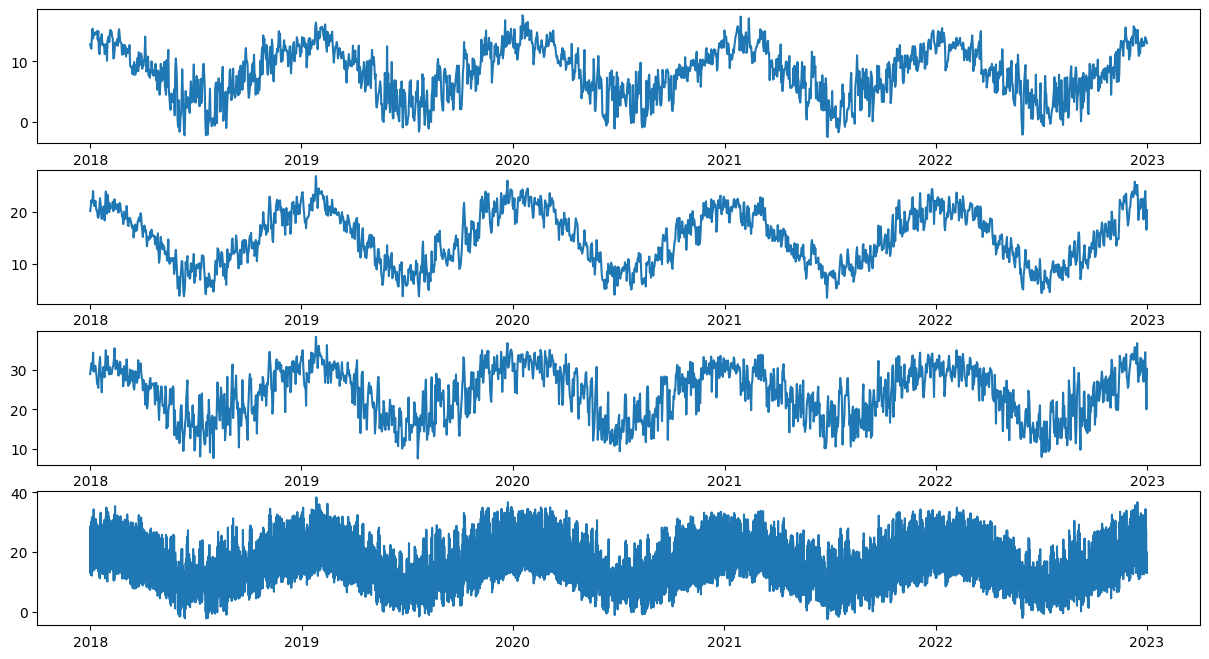

In [176]:
fig, axes = plt.subplots(4,1)
fig.set_size_inches(15, 8)
axes[0].plot(t_minima.index,t_minima);
axes[1].plot(t_media.index,t_media);
axes[2].plot(t_maxima.index,t_maxima)
axes[3].plot(t_interp.index,t_interp)


In [201]:
scaler = StandardScaler()
ds_train["consumption_std"] = scaler.fit_transform(np.array(ds_train["consumption"]).reshape(-1,1)) 
ds_test["consumption_std"] = scaler.fit_transform(np.array(ds_test["consumption"]).reshape(-1,1)) 

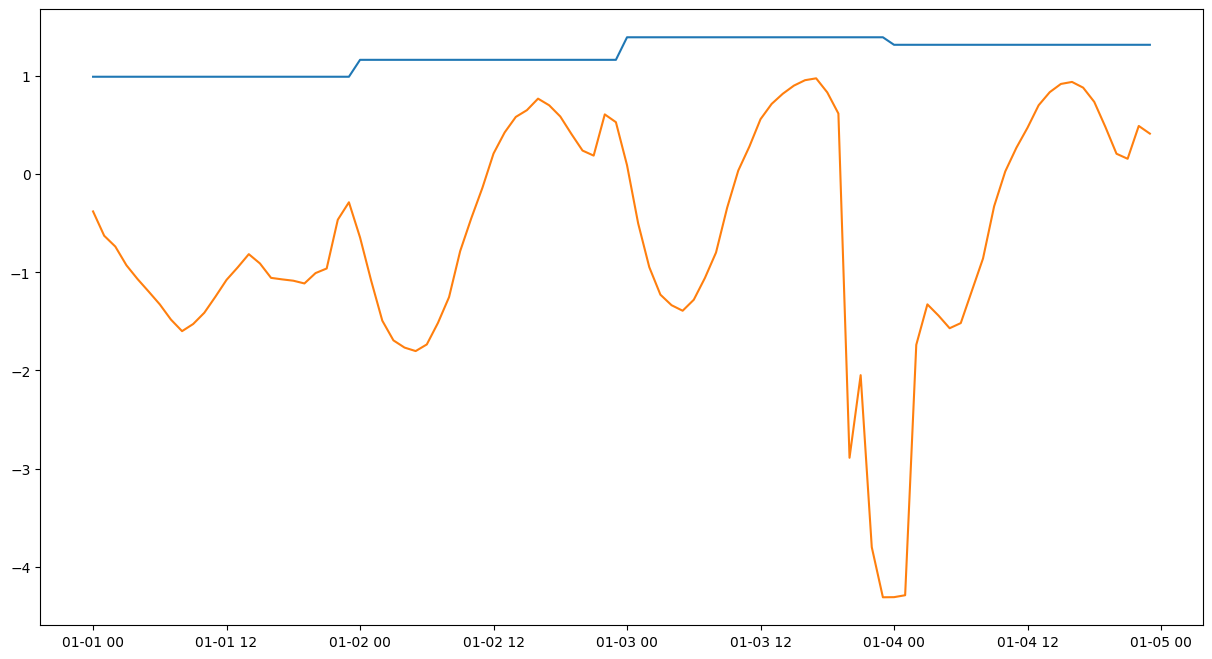

In [202]:
t_media_hora=t_media.resample("1h").ffill()
t_media_hora["t_media_std"] = scaler.fit_transform(np.array(t_media_hora["t_media"]).reshape(-1,1)) 
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(t_media_hora.index[:96],t_media_hora["t_media_std"][:96]);
axes.plot(ds_train.index[:96],ds_train["consumption_std"][:96]);

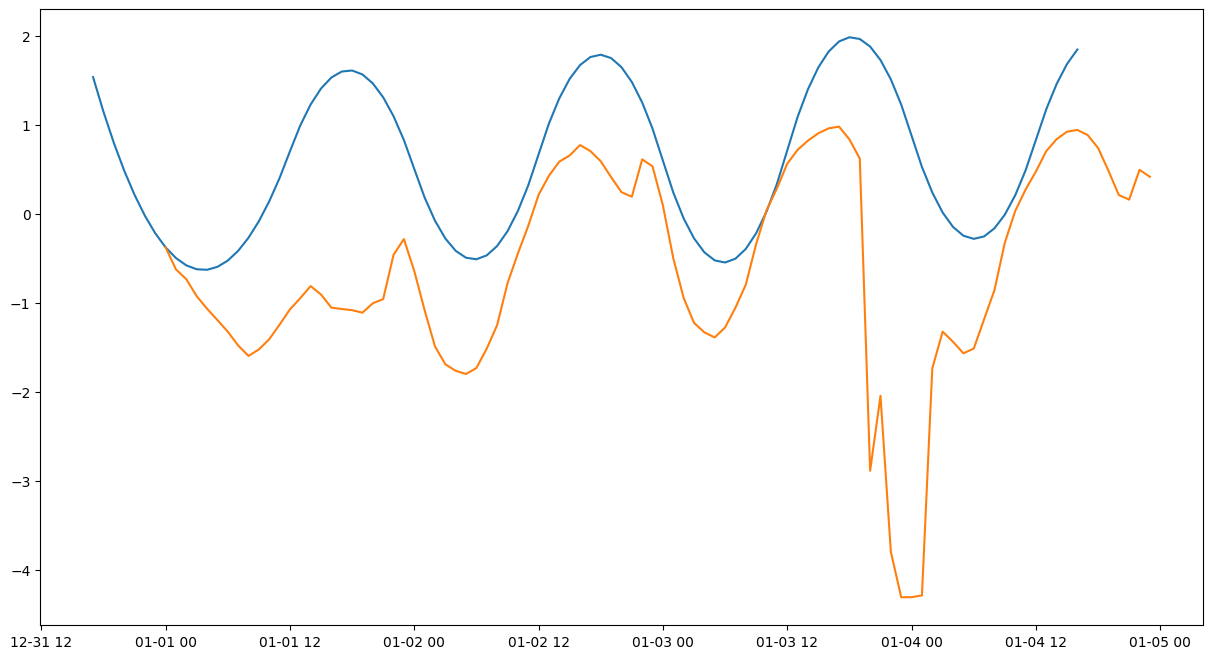

In [203]:
t_interp_hora=t_interp.resample("1h").interpolate(method='polynomial', order=2)
t_interp_hora["t_interp_std"] = scaler.fit_transform(np.array(t_interp_hora["t_interp"]).reshape(-1,1)) 
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(t_interp_hora.index[:96],t_interp_hora["t_interp_std"][:96]);
axes.plot(ds_train.index[:96],ds_train["consumption_std"][:96]);

In [204]:
t_maxima_hora=t_maxima.resample("1h").ffill()
t_minima_hora=t_minima.resample("1h").ffill()
print(len(t_minima_hora),len(t_media_hora),len(t_maxima_hora),365*5*24+1*24)

43825 43825 43825 43824


In [205]:
t_media_train=t_media_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_media_test=t_media_hora.query("date.dt.year==2022")
t_minima_train=t_minima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_minima_test=t_minima_hora.query("date.dt.year==2022")
t_maxima_train=t_maxima_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_maxima_test=t_maxima_hora.query("date.dt.year==2022")
t_interp_train=t_interp_hora.query("date.dt.year>2017 and date.dt.year<2022")
t_interp_test=t_interp_hora.query("date.dt.year==2022")

In [206]:
ds_train=ds_train.join(t_minima_train["t_minima"])
ds_train=ds_train.join(t_media_train["t_media"])
ds_train=ds_train.join(t_maxima_train["t_maxima"])
ds_train=ds_train.join(t_interp_train["t_interp"])
ds_train=ds_train.join(t_interp_train["t_interp_std"])
ds_train["w"]=ds_train.index.dayofweek
ds_train["m"]=ds_train.index.month
ds_train["h"]=ds_train.index.hour
print(pearsonr(ds_train["consumption"],ds_train["t_interp"]))
print(pearsonr(ds_train["consumption"],ds_train["t_media"]))
print(pearsonr(ds_train["consumption"],ds_train["t_minima"]))
print(pearsonr(ds_train["consumption"],ds_train["t_maxima"]))
print(pearsonr(ds_train["consumption"],ds_train["w"]))
print(pearsonr(ds_train["consumption"],ds_train["m"]))
print(pearsonr(ds_train["consumption"],ds_train["h"]))

PearsonRResult(statistic=0.13770873491426663, pvalue=5.26068851377794e-148)
PearsonRResult(statistic=-0.48083788888868956, pvalue=0.0)
PearsonRResult(statistic=-0.4364928885507775, pvalue=0.0)
PearsonRResult(statistic=-0.44762732525762555, pvalue=0.0)
PearsonRResult(statistic=-0.16901818798725682, pvalue=5.429055703234984e-223)
PearsonRResult(statistic=0.1265849293928329, pvalue=3.465196248245333e-125)
PearsonRResult(statistic=0.5246818887301639, pvalue=0.0)


In [207]:
ds_test=ds_test.join(t_minima_test["t_minima"])
ds_test=ds_test.join(t_media_test["t_media"])
ds_test=ds_test.join(t_maxima_test["t_maxima"])
ds_test=ds_test.join(t_interp_test["t_interp"])
ds_test=ds_test.join(t_interp_test["t_interp_std"])
ds_test["w"]=ds_test.index.dayofweek
ds_test["m"]=ds_test.index.month
ds_test["h"]=ds_test.index.hour
print(pearsonr(ds_test["consumption"],ds_test["t_interp"]))
print(pearsonr(ds_test["consumption"],ds_test["t_media"]))
print(pearsonr(ds_test["consumption"],ds_test["t_minima"]))
print(pearsonr(ds_test["consumption"],ds_test["t_maxima"]))
print(pearsonr(ds_test["consumption"],ds_test["w"]))
print(pearsonr(ds_test["consumption"],ds_test["m"]))
print(pearsonr(ds_test["consumption"],ds_test["h"]))

PearsonRResult(statistic=0.025497415845404003, pvalue=0.017010774902199717)
PearsonRResult(statistic=-0.5694986997612126, pvalue=0.0)
PearsonRResult(statistic=-0.5342029994894597, pvalue=0.0)
PearsonRResult(statistic=-0.5223074129267719, pvalue=0.0)
PearsonRResult(statistic=-0.1262871138294452, pvalue=1.784645742428329e-32)
PearsonRResult(statistic=0.03290210819630109, pvalue=0.002070958740669617)
PearsonRResult(statistic=0.47756823164543905, pvalue=0.0)


In [208]:
y_train=ds_train[["consumption","t_interp","w","h"]].to_numpy()
y_test=ds_test[["consumption","t_interp","w","h"]].to_numpy()
print(len(y_train)+len(y_test))

43824


In [209]:
yw_train=[]
ytw_train=[]
window=216
for i in range(0,len(y_train)):
    if i+window < len(y_train):
        row=[]
        for j in range(48):
            row.append(y_train[i+j])
        yw_train.append(row)
        row=[]
        for j in range(168):
            row.append(y_train[i+48+j][0])
        ytw_train.append(row)
    else:
        break
yw_train=np.asarray(yw_train)
ytw_train=np.asarray(ytw_train)
print(yw_train.shape,ytw_train.shape)

(34848, 48, 4) (34848, 168)


In [210]:
yw_test=[]
ytw_test=[]
window=216
for i in range(0,len(y_test)):
    if i+window < len(y_test):
        row=[]
        for j in range(48):
            row.append(y_test[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(y_test[i+48+j][0])
        ytw_test.append(row)
    else:
        break
yw_test=np.asarray(yw_test)
ytw_test=np.asarray(ytw_test)
print(yw_test.shape,ytw_test.shape)

(8544, 48, 4) (8544, 168)


In [212]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense,Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random as rd

In [213]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(48,4)))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dense(168, activation='linear'))
tag="rnn_htw"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-5)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw_train, ytw_train, validation_data=(yw_test,ytw_test),
                batch_size=256, epochs=16,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 517ms/step - loss: 18.3506 - mae: 18.8447 - mse: 583.4572 - val_loss: 11.5268 - val_mae: 12.0224 - val_mse: 229.2002
Epoch 2/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 512ms/step - loss: 9.7119 - mae: 10.2026 - mse: 156.6505 - val_loss: 9.7664 - val_mae: 10.2523 - val_mse: 151.9491
Epoch 3/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 71s 518ms/step - loss: 8.8096 - mae: 9.2998 - mse: 126.9350 - val_loss: 7.9411 - val_mae: 8.4362 - val_mse: 112.9876
Epoch 4/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 527ms/step - loss: 6.6788 - mae: 7.1638 - mse: 84.8052 - val_loss: 6.0998 - val_mae: 6.6099 - val_mse: 74.4200
Epoch 5/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 494ms/step - loss: 5.4761 - mae: 5.9565 - mse: 63.8679 - val_loss: 5.5930 - val_mae: 6.0985 - val_mse: 64.6129
Epoch 6/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 70s 510ms/step - loss: 4.9070 - mae: 5.3842 - mse: 54.8177 - val_loss: 5.2197 - val_mae: 5.7230 - val_mse: 57.0547
Epoch 7/16
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 458ms/step - l

In [215]:
ultimo=yw_test[0].reshape(1,48,4)
ultimo.shape

(1, 48, 4)

31.84599220386905 2.922135776367187 0.09175835243758458 0.10289756563577121


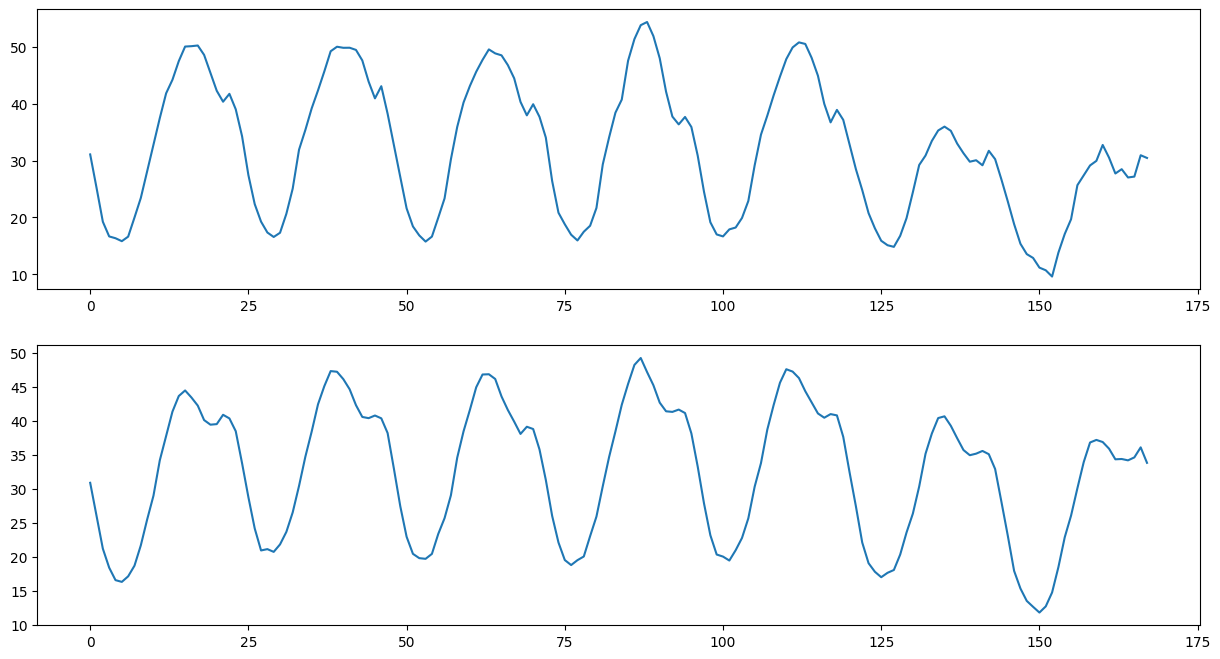

In [217]:
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=ytw_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
error2=mean_absolute_percentage_error(real,pred)
print(media,error,error/media,error2)